In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

Using TensorFlow backend.


In [3]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict



neurons=66
batch_size=66
dsnum=20
verbose_level=1

In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
pathds = '/home/user/01Code/00Datasets_final/'

In [6]:
#df_chunk = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv', chunksize=1000)
#df = df_chunk.get_chunk(300000)
df = pd.read_csv(pathds+"SubsetAllSamples/CloneID"+str(dsnum)+"bal_stdscal.csv")

In [7]:
df.shape

(2686202, 67)

#### 4.2 Explaining the data

In [8]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 1343101
Class 1: 1343101
Proportion: 1.0 : 1


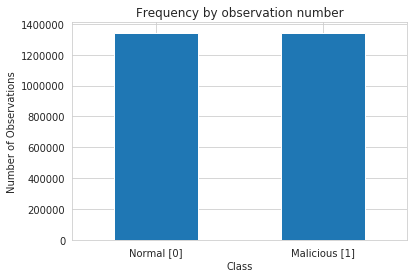

In [9]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [10]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [11]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [12]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [13]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, batch_size].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, batch_size].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, batch_size].sum()/test_df.shape[0])

0.5000465341374433
0.49896578120164825
0.5006784664610482


In [14]:
train_x = train_df.iloc[:, :batch_size] 
dev_x = dev_df.iloc[:, :batch_size] 
test_x = test_df.iloc[:, :batch_size] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [15]:
# Define the final train and test sets
train_y = train_df.iloc[:,batch_size]
dev_y = dev_df.iloc[:,batch_size]
test_y = test_df.iloc[:,batch_size]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [16]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

66


### Autoencoder Function

In [17]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [18]:
def spae(factor_enc_dim,dec_activation,enc_activation,
         optimizer,loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [19]:
def to_pca(thr):
    #train_x_pca,test_x_pca = to_pca(0.95)
    pca = PCA(n_components = thr, svd_solver = 'full')
    train_x_ = np.array(train_x)
    print(type(train_x_))

    test_x_ = np.array(test_x)
    print(type(test_x_))
    
    start_time = time.time()
    print(time.ctime(start_time))

    train_x_pca = pca.fit_transform(train_x_)
    print(train_x_pca.shape)

    test_x_pca = pca.fit_transform(test_x_)
    print(test_x_pca.shape)

    elapsed_time = (time.time() - start_time)

    print("--- PCA spent %s seconds ---" %elapsed_time )
    
    return  train_x_pca,test_x_pca

In [20]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=verbose_level)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=verbose_level,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    elapsed_time = (time.time() - start_time)
    print("--- AE spent %s seconds ---" % elapsed_time)
    
    return hist_auto

In [21]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [22]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(int(neurons-int(neurons/4)), activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(int(neurons-int((neurons/4)*2)), activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [23]:
def ann_2h_():

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_dim,
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(int(neurons-int(neurons/4)), activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(int(neurons-int((neurons/4)*2)), activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [24]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=verbose_level)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping, cp, tb],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=verbose_level)

    elapsed_time = (time.time() - start_time)
    print("--- ANN spent %s seconds ---" % elapsed_time)

    return history

In [25]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob, pred_ann_01

In [26]:
def ann_predict_():
    early_stopping = EarlyStopping(monitor='loss', patience=10)

    start_time = time.time()
    print(time.ctime(start_time))    

    modelk = KerasClassifier(build_fn=ann_2h_,
                             epochs=epochs, 
                             batch_size=batch_size, 
                             verbose=verbose_level
                            )

    pred_ann_prob = cross_val_predict(modelk,
                                      enc_test_x,
                                      test_y,
                                      cv=KFold(n_splits=5, random_state=23),
                                      verbose=1)

    elapsed_time = (time.time() - start_time)
    print("--- %s seconds ---" %elapsed_time)

    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)

    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob,pred_ann_01

In [27]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()
    

### **---------- PCA Dimensionality reduction ----------**

In [28]:
train_x_pca,test_x_pca = to_pca(0.95)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Sun Jun 23 09:07:35 2019
(1719168, 18)
(537241, 18)
--- PCA spent 15.570057392120361 seconds ---


### **---------- AE Dimensionality reduction ----------**

In [29]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 44)                2948      
_________________________________________________________________
dense_1 (Dense)              (None, 66)                2970      
Total params: 5,918
Trainable params: 5,918
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [31]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "./H5files/ae_sigmoid_adam_mse_fullds"+str(dsnum)+"bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = batch_size,
                                  shuffle = False)

Sun Jun 23 09:10:53 2019
Instructions for updating:
Use tf.cast instead.
Train on 1719168 samples, validate on 429793 samples
Epoch 1/200
1719168/1719168 [==============================] - 52s 30us/step - loss: 0.1593 - acc: 0.1771 - val_loss: 0.1570 - val_acc: 0.1991

Epoch 00001: val_loss improved from inf to 0.15705, saving model to ./H5files/ae_sigmoid_adam_mse_fullds20bal.h5
Epoch 2/200
1719168/1719168 [==============================] - 47s 28us/step - loss: 0.1570 - acc: 0.1960 - val_loss: 0.1570 - val_acc: 0.2130

Epoch 00002: val_loss improved from 0.15705 to 0.15704, saving model to ./H5files/ae_sigmoid_adam_mse_fullds20bal.h5
Epoch 3/200
1719168/1719168 [==============================] - 44s 26us/step - loss: 0.1570 - acc: 0.1964 - val_loss: 0.1570 - val_acc: 0.1956

Epoch 00003: val_loss improved from 0.15704 to 0.15704, saving model to ./H5files/ae_sigmoid_adam_mse_fullds20bal.h5
Epoch 4/200
1719168/1719168 [==============================] - 44s 26us/step - loss: 0.1570 - a

Best loss value: 0.15686196325025326


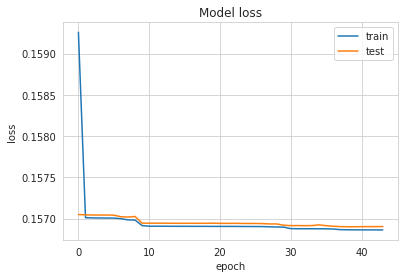

In [32]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse_fullds.png')

### **---------- SPAE Dimensionality reduction ----------**

In [47]:
spae_sigmoid_adam_mse,enc_train_x_spsam,enc_test_x_spsam = spae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 66)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 44)                2948      
_________________________________________________________________
dense_10 (Dense)             (None, 66)                2970      
Total params: 5,918
Trainable params: 5,918
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
#spae_sigmoid_adam_mse = load_model('spae_sigmoid_adam_mse_redds20bal.h5')

In [49]:
hist_spae_sigmoid_adam_mse = fit_ae(checkpoint_file = "./H5files/spae_sigmoid_adam_mse_fullds"+str(dsnum)+"bal.h5",
                                  autoencoder = spae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = batch_size,
                                  shuffle = False)

Sun Jun 23 19:01:30 2019
Train on 1719168 samples, validate on 429793 samples
Epoch 1/200
1719168/1719168 [==============================] - 50s 29us/step - loss: 0.1954 - acc: 0.1502 - val_loss: 0.1778 - val_acc: 0.1242

Epoch 00001: val_loss improved from inf to 0.17782, saving model to ./H5files/spae_sigmoid_adam_mse_fullds20bal.h5
Epoch 2/200
1719168/1719168 [==============================] - 49s 29us/step - loss: 0.1737 - acc: 0.1225 - val_loss: 0.1713 - val_acc: 0.1484

Epoch 00002: val_loss improved from 0.17782 to 0.17128, saving model to ./H5files/spae_sigmoid_adam_mse_fullds20bal.h5
Epoch 3/200
1719168/1719168 [==============================] - 51s 30us/step - loss: 0.1700 - acc: 0.1863 - val_loss: 0.1690 - val_acc: 0.2191

Epoch 00003: val_loss improved from 0.17128 to 0.16897, saving model to ./H5files/spae_sigmoid_adam_mse_fullds20bal.h5
Epoch 4/200
1719168/1719168 [==============================] - 49s 28us/step - loss: 0.1681 - acc: 0.2427 - val_loss: 0.1674 - val_acc: 0

Best loss value: 0.16223074628940626


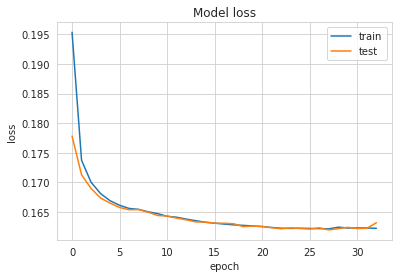

In [50]:
best_loss_value_spae_sigmoid_adam_mse  = plot_hist_auto(hist_spae_sigmoid_adam_mse, './Figures/hist_spae_sigmoid_adam_mse_fullds.png')

In [51]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_spae_sigmoid_adam_mse': best_loss_value_spae_sigmoid_adam_mse
    }

In [52]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_mse': 0.15686196325025326,
 'loss_value_spae_sigmoid_adam_mse': 0.16223074628940626}

In [53]:
print(enc_train_x_asam.shape)
print(enc_test_x_asam.shape)

print(enc_train_x_spsam.shape)
print(enc_test_x_spsam.shape)

(1719168, 44)
(537241, 44)
(1719168, 44)
(537241, 44)


### **---------- ANN with ae encoded DS ----------**

In [33]:
ae_ann_2h_unisoftsigbinlosadam1 = ann_2h(neurons=neurons,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 66)                2970      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3350      
_________________________________________________________________
dense_4 (Dense)              (None, 33)                1683      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33)                132       
_________________________________________________________________
dropout_1 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 34        
Total params: 8,169
Trainable params: 8,103
Non-trainable params: 66
_________________________________________________________________
None


In [34]:
hist_ae_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "./H5files/ae_ann_2h_unisoftsigbinlosadam_fullds"+str(dsnum)+"bal.h5",
                                        ann = ae_ann_2h_unisoftsigbinlosadam1,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = batch_size)

Sun Jun 23 10:22:00 2019
Train on 1375334 samples, validate on 343834 samples
Epoch 1/200
1375334/1375334 [==============================] - 78s 57us/step - loss: 0.4638 - acc: 0.7637 - val_loss: 0.3820 - val_acc: 0.8158

Epoch 00001: val_loss improved from inf to 0.38197, saving model to ./H5files/ae_ann_2h_unisoftsigbinlosadam_fullds20bal.h5
Epoch 2/200
1375334/1375334 [==============================] - 75s 55us/step - loss: 0.3442 - acc: 0.8346 - val_loss: 0.3152 - val_acc: 0.8526

Epoch 00002: val_loss improved from 0.38197 to 0.31516, saving model to ./H5files/ae_ann_2h_unisoftsigbinlosadam_fullds20bal.h5
Epoch 3/200
1375334/1375334 [==============================] - 77s 56us/step - loss: 0.3116 - acc: 0.8501 - val_loss: 0.2930 - val_acc: 0.8608

Epoch 00003: val_loss improved from 0.31516 to 0.29301, saving model to ./H5files/ae_ann_2h_unisoftsigbinlosadam_fullds20bal.h5
Epoch 4/200
1375334/1375334 [==============================] - 76s 55us/step - loss: 0.2940 - acc: 0.8585 - va

In [35]:
# hist_ae_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.22846439682668718


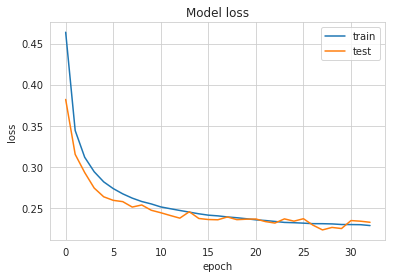

In [36]:
best_loss_value_ae_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ae_ann_2h_unisoftsigbinlosadam, './Figures/ae_ann_2h_unisoftsigbinlosadam'+str(dsnum)+'.png')

In [38]:
pred_ae_ann_2h_prob_unisoftsigbinlosadam, pred_ae_ann_2h_01_unisoftsigbinlosadam = ann_predict(ae_ann_2h_unisoftsigbinlosadam1,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.8936008234665634
              precision    recall  f1-score   support

           0     0.8990    0.8865    0.8927    268256
           1     0.8884    0.9007    0.8945    268985

   micro avg     0.8936    0.8936    0.8936    537241
   macro avg     0.8937    0.8936    0.8936    537241
weighted avg     0.8937    0.8936    0.8936    537241



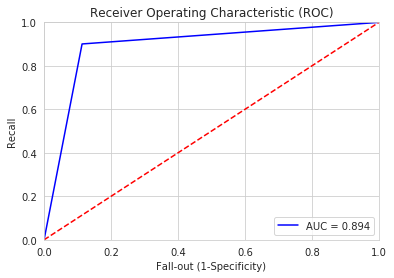

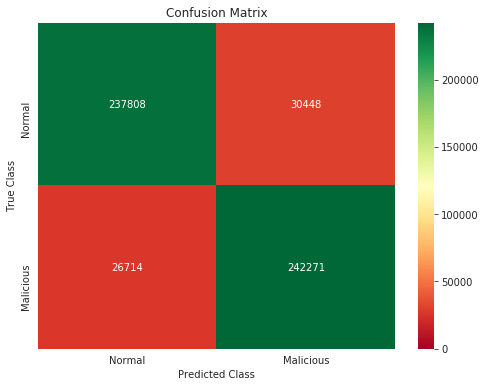

In [39]:
plot_roc_cm(pred_ae_ann_2h_01_unisoftsigbinlosadam, pred_ae_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ae_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_ae_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

In [ ]:
# enc_train_x=enc_train_x_asam
# input_dim=enc_train_x.shape[1]
# enc_test_x=enc_test_x_asam
# test_y=test_y
# train_y=train_y
# init_mode='uniform'
# activation_input='relu'
# weight_constraint=5
# dropout_rate=0.0
# activation_output='sigmoid'
# loss='binary_crossentropy'
# optimizer='Adam'

# epochs=100

In [ ]:
# pred_ae_ann_2h_prob_unisoftsigbinlosadam,pred_ae_ann_2h_01_unisoftsigbinlosadam = ann_predict_()

In [ ]:
# plot_roc_cm(pred_ae_ann_2h_01_unisoftsigbinlosadam, pred_ae_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ae_ann_2h_unisoftsigbinlosadam_fullds'+str(dsnum)+'bal.png', './Figures/CM_ae_ann_2h_unisoftsigbinlosadam_fullds'+str(dsnum)+'bal.png')

### **---------- ANN with spae encoded DS ----------**

In [ ]:
sp_ann_2h_unisoftsigbinlosadam1 = ann_2h(neurons=neurons,
                                      encoded_train_x=enc_train_x_spsam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

In [ ]:
hist_sp_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "./H5files/ann_2h_unisoftsigbinlosadam_fullds"+str(dsnum)+"bal.h5",
                                        ann = sp_ann_2h_unisoftsigbinlosadam1,
                                        enc_train_x = enc_train_x_spsam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = batch_size)

In [ ]:
# hist_sp_ann_2h_unisoftsigbinlosadam.model.get_weights()

In [ ]:
# best_loss_value_sp_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_sp_ann_2h_unisoftsigbinlosadam, './Figures/sp_ann_2h_unisoftsigbinlosadam'+str(dsnum)+'.png')

In [ ]:
# pred_sp_ann_2h_prob_unisoftsigbinlosadam, pred_sp_ann_2h_01_unisoftsigbinlosadam = ann_predict(sp_ann_2h_unisoftsigbinlosadam,enc_test_x_spsam)

In [ ]:
# plot_roc_cm(pred_sp_ann_2h_prob_unisoftsigbinlosadam, pred_sp_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_sp_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_sp_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

In [ ]:
enc_train_x=enc_train_x_asam
input_dim=enc_train_x.shape[1]
enc_test_x=enc_test_x_spsam
test_y=test_y
train_y=train_y
init_mode='uniform'
activation_input='relu'
weight_constraint=5
dropout_rate=0.0
activation_output='sigmoid'
loss='binary_crossentropy'
optimizer='Adam'

epochs=100

In [ ]:
pred_sp_ann_2h_prob_unisoftsigbinlosadam,pred_sp_ann_2h_01_unisoftsigbinlosadam = ann_predict_()

In [ ]:
plot_roc_cm(pred_sp_ann_2h_prob_unisoftsigbinlosadam, pred_sp_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_sp_ann_2h_unisoftsigbinlosadam_fullds'+str(dsnum)+'bal.png', './Figures/CM_sp_ann_2h_unisoftsigbinlosadam_fullds'+str(dsnum)+'bal.png')

### **---------- ANN with no encoded DS ----------**

In [40]:
nodr_ann_2h_unisoftsigbinlosadam1 = ann_2h(neurons=neurons,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 66)                4422      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                3350      
_________________________________________________________________
dense_8 (Dense)              (None, 33)                1683      
_________________________________________________________________
batch_normalization_2 (Batch (None, 33)                132       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 34        
Total params: 9,621
Trainable params: 9,555
Non-trainable params: 66
_________________________________________________________________
None


In [41]:
hist_nodr_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "./H5files/ann_2h_unisoftsigbinlosadam_fullds"+str(dsnum)+"bal.h5",
                                        ann = nodr_ann_2h_unisoftsigbinlosadam1,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = batch_size)

Sun Jun 23 11:41:31 2019
Train on 1375334 samples, validate on 343834 samples
Epoch 1/200
1375334/1375334 [==============================] - 80s 58us/step - loss: 0.3403 - acc: 0.8309 - val_loss: 0.2359 - val_acc: 0.8894

Epoch 00001: val_loss improved from inf to 0.23586, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_fullds20bal.h5
Epoch 2/200
1375334/1375334 [==============================] - 76s 55us/step - loss: 0.2301 - acc: 0.8904 - val_loss: 0.2051 - val_acc: 0.9054

Epoch 00002: val_loss improved from 0.23586 to 0.20509, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_fullds20bal.h5
Epoch 3/200
1375334/1375334 [==============================] - 75s 55us/step - loss: 0.2016 - acc: 0.9045 - val_loss: 0.1860 - val_acc: 0.9132

Epoch 00003: val_loss improved from 0.20509 to 0.18596, saving model to ./H5files/ann_2h_unisoftsigbinlosadam_fullds20bal.h5
Epoch 4/200
1375334/1375334 [==============================] - 74s 54us/step - loss: 0.1849 - acc: 0.9130 - val_loss: 0

In [42]:
# hist_nodr_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.1293866893265838


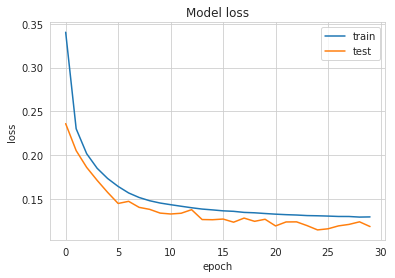

In [43]:
best_loss_value_nodr_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_nodr_ann_2h_unisoftsigbinlosadam, './Figures/nodr_ann_2h_unisoftsigbinlosadam'+str(dsnum)+'.png')

In [45]:
pred_nodr_ann_2h_prob_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam = ann_predict(nodr_ann_2h_unisoftsigbinlosadam1,test_x)

Overall accuracy of Neural Network model: 0.9449446337863268
              precision    recall  f1-score   support

           0     0.9465    0.9430    0.9448    268256
           1     0.9434    0.9469    0.9451    268985

   micro avg     0.9449    0.9449    0.9449    537241
   macro avg     0.9450    0.9449    0.9449    537241
weighted avg     0.9450    0.9449    0.9449    537241



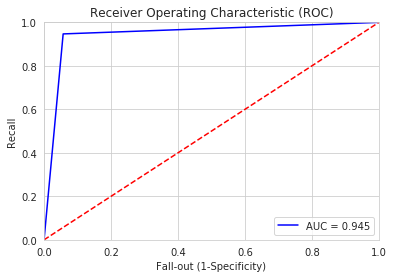

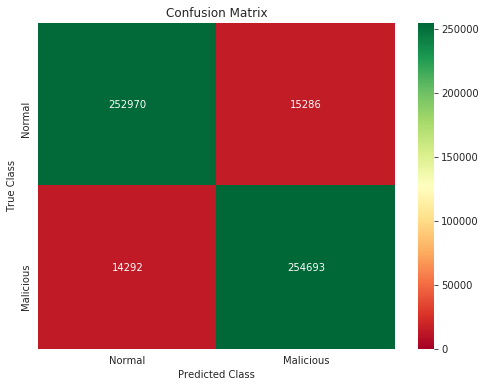

In [46]:
plot_roc_cm(pred_nodr_ann_2h_01_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_nodr_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png', './Figures/CM_nodr_ann_2h_unisoftsigbinlosadam_redds'+str(dsnum)+'bal.png')

In [ ]:
# enc_train_x=train_x
# input_dim=enc_train_x.shape[1]
# enc_test_x=test_x
# test_y=test_y
# train_y=train_y
# init_mode='uniform'
# activation_input='relu'
# weight_constraint=5
# dropout_rate=0.0
# activation_output='sigmoid'
# loss='binary_crossentropy'
# optimizer='Adam'

# epochs=100

In [ ]:
# pred_nodr_ann_2h_prob_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam = ann_predict_()

In [ ]:
# plot_roc_cm(pred_nodr_ann_2h_01_unisoftsigbinlosadam, pred_nodr_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_nodr_ann_2h_unisoftsigbinlosadam_fullds'+str(dsnum)+'bal.png', './Figures/CM_nodr_ann_2h_unisoftsigbinlosadam_fullds'+str(dsnum)+'bal.png')

### **---------- RF with ae encoded DS ----------**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
#                              min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.3, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [ ]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_asam, train_y)

pred_y_ae_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_asam),
                              y=test_y,
                              cv=KFold(n_splits=5, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_ae_RF,digits=4))

In [ ]:
plot_roc_cm(pred_y_ae_RF, pred_y_ae_RF, './Figures/ROC_ae_rf_E100MaxfautoMaxdnoneBootT_fullds'+str(dsnum)+'bal.png', './Figures/CM_ae_rf_E100MaxfautoMaxdnoneBootT_fullds'+str(dsnum)+'bal.png')

### **---------- RF with spae encoded DS ----------**

In [ ]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_spsam, train_y)

pred_y_spae_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_spsam),
                              y=test_y,
                              cv=KFold(n_splits=5, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_spae_RF,digits=4))

In [ ]:
plot_roc_cm(pred_y_spae_RF, pred_y_spae_RF, './Figures/ROC_spae_rf_E100MaxfautoMaxdnoneBootT_fullds'+str(dsnum)+'bal.png', './Figures/CM_spae_rf_E100MaxfautoMaxdnoneBootT_fullds'+str(dsnum)+'bal.png')

### **---------- RF with pca DS ----------**

In [ ]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(train_x_pca, train_y)

pred_y_pca_RF = cross_val_predict(estimator=clf,
                              X=np.array(test_x_pca),
                              y=test_y,
                              cv=KFold(n_splits=5, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_pca_RF,digits=4))

In [ ]:
plot_roc_cm(pred_y_pca_RF, pred_y_pca_RF, './Figures/ROC_pca_rf_E100MaxfautoMaxdnoneBootT_fullds'+str(dsnum)+'bal.png', './Figures/CM_pca_rf_E100MaxfautoMaxdnoneBootT_fullds'+str(dsnum)+'bal.png')